In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import pprint, os, logging, sys
from win32com.shell import shell, shellcon
log_fmt = '%(asctime)s | %(levelname)s : %(message)s'
logging.basicConfig(format=log_fmt, level=logging.INFO, stream=sys.stdout)
logging.info(f"Start with tf version={tf.version.VERSION}")

2020-10-02 16:26:17,108 | INFO : Start with tf version=2.3.1


In [2]:
pictures_path = shell.SHGetFolderPath(0, shellcon.CSIDL_MYPICTURES, None, 0)
timesnapper_path = os.path.sep.join([pictures_path, 'Timesnapper_Snapshots'])
timesnapper_csv = os.path.sep.join([timesnapper_path, 'timesnapper_log.csv'])
logging.info(f"Timesnapper log at {timesnapper_csv}")

ts_batched_ds = tf.data.experimental.make_csv_dataset(
    file_pattern=timesnapper_csv, 
    batch_size=1,
    num_parallel_reads=20,
    shuffle=False).unbatch()

ts_batched_ds = \
    ts_batched_ds.filter(
        lambda item:tf.py_function(
            lambda fn:tf.io.gfile.exists(fn.numpy()), 
            [item['FileName']], tf.bool))

ts_batched_ds = \
    ts_batched_ds.filter(
        lambda item:item['Program'] == 'msedge.exe')

# show a few
for batch in ts_batched_ds.batch(3).take(3):
    logging.info("-----------")
    for item in batch:
        logging.info(f"{item}: {batch[item]}")

2020-10-02 16:26:21,323 | INFO : Timesnapper log at E:\Users\local_dev\Pictures\Timesnapper_Snapshots\timesnapper_log.csv
2020-10-02 16:26:22,216 | INFO : -----------
2020-10-02 16:26:22,217 | INFO : ID: [54409 54410 54411]
2020-10-02 16:26:22,218 | INFO : Time: [b'7/27/2020 12:00:00 AM' b'7/27/2020 12:00:00 AM'
 b'7/27/2020 12:00:00 AM']
2020-10-02 16:26:22,218 | INFO : Date: [b'1/1/1970 9:36:00 AM' b'1/1/1970 9:36:30 AM' b'1/1/1970 9:37:00 AM']
2020-10-02 16:26:22,219 | INFO : FileName: [b'E:\\Users\\local_dev\\Pictures\\Timesnapper_Snapshots\\2020-07-27\\09.36.00.900.png'
 b'E:\\Users\\local_dev\\Pictures\\Timesnapper_Snapshots\\2020-07-27\\09.36.30.898.png'
 b'E:\\Users\\local_dev\\Pictures\\Timesnapper_Snapshots\\2020-07-27\\09.37.00.898.png']
2020-10-02 16:26:22,220 | INFO : FileSize: [1288904 1230234 1309098]
2020-10-02 16:26:22,221 | INFO : Program: [b'msedge.exe' b'msedge.exe' b'msedge.exe']
2020-10-02 16:26:22,222 | INFO : Caption: [b'you need to learn Docker RIGHT NOW!! // D

In [3]:
def process_batch_pixels(batch_dict):
    """ """
    batch_dict = batch_dict.copy()
    
    # read and resize image
    pixels = tf.io.decode_png(tf.io.read_file(batch_dict['FileName']))
    pixels = tf.image.resize(pixels, (256,256))

    # whiten image
    img_max, img_min = tf.math.reduce_max(pixels), tf.math.reduce_min(pixels)
    pixels -= img_min
    pixels /= (img_max - img_min)
    batch_dict['Pixels'] = pixels    
    return batch_dict

ts_batched_ds_w_pixels = ts_batched_ds.map(process_batch_pixels)
for batch in ts_batched_ds_w_pixels.batch(3):
    logging.info("-----------")
    for item in batch:
        if item == 'Pixels':
            logging.info(f"{item}: {batch[item].shape}")
        else:
            logging.info(f"{item}: {batch[item]}")
    break

2020-10-02 16:26:25,715 | INFO : -----------
2020-10-02 16:26:25,717 | INFO : ID: [54409 54410 54411]
2020-10-02 16:26:25,717 | INFO : Time: [b'7/27/2020 12:00:00 AM' b'7/27/2020 12:00:00 AM'
 b'7/27/2020 12:00:00 AM']
2020-10-02 16:26:25,718 | INFO : Date: [b'1/1/1970 9:36:00 AM' b'1/1/1970 9:36:30 AM' b'1/1/1970 9:37:00 AM']
2020-10-02 16:26:25,719 | INFO : FileName: [b'E:\\Users\\local_dev\\Pictures\\Timesnapper_Snapshots\\2020-07-27\\09.36.00.900.png'
 b'E:\\Users\\local_dev\\Pictures\\Timesnapper_Snapshots\\2020-07-27\\09.36.30.898.png'
 b'E:\\Users\\local_dev\\Pictures\\Timesnapper_Snapshots\\2020-07-27\\09.37.00.898.png']
2020-10-02 16:26:25,719 | INFO : FileSize: [1288904 1230234 1309098]
2020-10-02 16:26:25,721 | INFO : Program: [b'msedge.exe' b'msedge.exe' b'msedge.exe']
2020-10-02 16:26:25,722 | INFO : Caption: [b'you need to learn Docker RIGHT NOW!! // Docker Containers 101 - YouTube - Personal - Microsoft? Edge'
 b'you need to learn Docker RIGHT NOW!! // Docker Containers 

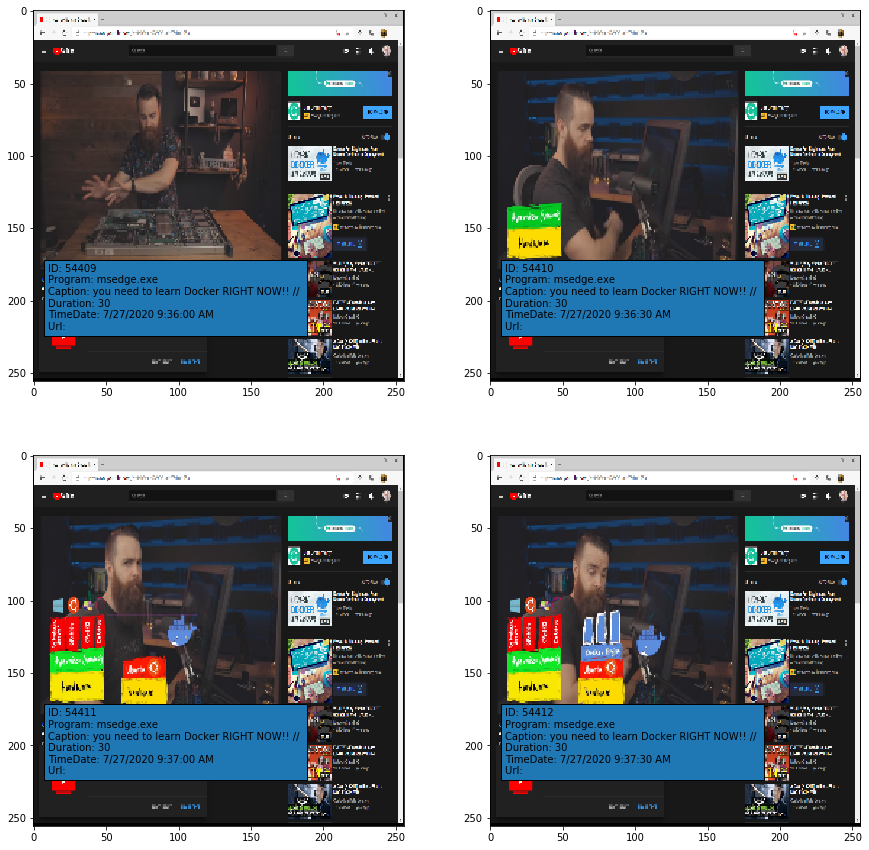

In [8]:
count = 0
fig,axs = plt.subplots(2,2, figsize=(15,15))
skip_columns = ['Time', 'Date', 'FileName', 'FileSize', 'Blank1', 'Blank2']
for batch in ts_batched_ds_w_pixels.take(4):
    for_axs, overlay = axs[count // 2][count % 2], []
    for item in batch:
        if item == 'Pixels':
            for_axs.imshow(batch[item], cmap='gray')
        elif not item in skip_columns:
            value = batch[item].numpy()
            if isinstance(value, bytes):
                value = value.decode("utf-8")
                value = value[:40]
            overlay.append(f"{item}: {value}")
    for_axs.text(10, 220, "\n".join(overlay), bbox=dict(fill=True))
    count = (count+1) % 4